# SCAnalysis for single cell RNA-seq

This notebook details the usage of SCAnalysis for single cell RNA-seq data.

To view directly: https://nbviewer.jupyter.org/github/helenjin/scanalysis/blob/master/notebooks/SCAnalysis.ipynb
*(ignore if already here)*

## Table of Contents

1. [Introduction](#intro)
2. [Loading Data](#loading)
3. [Data Preprocessing](#preprocessing):
    *a. [Data Filtering](#filter)
    b. [Data Normalization](#norm)
    c. [PCA](#pca)
    d. [Diffusion maps](#dmap)
    e. [tSNE](#tsne)*
4. [Saving data](#savedata)
5. [General Plots](#genplot):
    *a. [PCA visualization](#pcavisual)
    b. [tSNE visualization](#tsnevisual)
    c. [Diffusion maps visualization](#dmvisual)*   
6. [Gene Set Enrichment Analysis (GSEA)](#gsea)
7. [Running Wishbone](#wishbone)
8. [Plotting Wishbone Results](#wbplot)
9. [Running MAGIC](#magic)
10. [Plotting MAGIC Results](#mgplot)
11. [Saving figures](#savefig)
12. [Running Palantir](#palantir)
13. [Plotting Palantir Results](#prplot)
14. [References](#ref)

<a id="intro"></a>
## Introduction

SCAnalysis is a package for analyzing single cell data. It includes the Wishbone, MAGIC, and Palantir packages:

* Wishbone is an algorithm to identify bifurcating developmental trajectories from single cell data. Wishbone can applied to single cell RNA-seq (as for mass cytometry datasets--> not currently)

* MAGIC (Markov-Affinity Based Graph Imputation of Cells) is an interactive tool to impute missing values in single-cell data and restore the structure of the data. It also provides data preprocessing functionality such as dimensionality reduction and gene expression visualization.

* Palantir -tbd

<a id="loading"></a>
## Loading Data

First, import the package.

In [17]:
import scanalysis

Then, you can load the data using the load function in the loadsave file of the io folder. Here, we will be using the sample_scseq_data.csv data provided in the data folder as an example.

In [18]:
df = scanalysis.io.loadsave.load("~/scanalysis/data/sample_scseq_data.csv")

Successfully loaded /Users/hjin/scanalysis/data/sample_scseq_data.csv


Also, import plotting and miscellaneous.

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

<a id="preprocessing"></a>
## Data preprocessing 

<a id="filter"></a>
### Data filtering

In [ ]:
fig, ax = scanalysis.plots.plot.plot_molecules_per_cell_and_gene(df)

From these histograms, choose the appropriate cutoffs to filter the data. In this case, the data has already been filtered.

In [5]:
# Minimum molecules/cell value
CELL_MIN = 0

# Maximum molecules/cell values
CELL_MAX = 1000000

# Minimum number of nonzero cells/gene 
# (None if no filtering desired)
GENE_NONZERO = None

# Minimum number of molecules/gene
# (None if no filtering desired)
GENE_MOLECULES = None

In [4]:
df = scanalysis.io.preprocess.filter_scseq_data(df, filter_cell_min=CELL_MIN, filter_cell_max=CELL_MAX, 
                         filter_gene_nonzero=GENE_NONZERO, filter_gene_mols=GENE_MOLECULES)

NameError: name 'CELL_MIN' is not defined

<a id="norm"></a>
### Data normalization

In [25]:
data = scanalysis.io.preprocess.normalize_scseq_data(df)

Successfully normalized data


<a id="pca"></a>
### Principal Component Analysis (PCA)

The first step in data processing for Wishbone is to determine metagenes using principal component analysis. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data.

For a visual representation of PCA results, see [PCA visualization](#pcavisual). *However, note that the PCA visualization functions already run PCA within themselves, so there is no need to run PCA separately beforehand.*

In [ ]:
r1, r2 = scanalysis.utils.pca.run_pca(data)

##### *Note: This sample dataset is especially sensitive, so we will be using the PCA of the original Wishbone package. (as shown below)

temp is the data after PCA is run on it.

In [13]:
import wishbone
import os

scdata = wishbone.wb.SCData.from_csv(os.path.expanduser('~/.wishbone/data/sample_scseq_data.csv'), data_type='sc-seq', normalize=True)
scdata.run_pca()

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [14]:
from copy import deepcopy
import numpy as np
import pandas as pd

n_pca_components = 5
temp = deepcopy(scdata.data)
temp -= np.min(np.ravel(temp))
temp /= np.max(np.ravel(temp))
temp = pd.DataFrame(np.dot(temp, scdata.pca['loadings'].iloc[:, 0:n_pca_components]),
                    index=scdata.data.index)

<a id="dmap"></a>
### Diffusion Maps

Diffusion maps is a non-linear dimensionality reduction technique to denoise the data and capture the major axes of variation. Diffusion maps can be determined by using the run_diffusion_map function and the diffusion components visualized on tSNE maps using plot_diffusion_components. See [Diffusion map visualization](#dmvisual)

Note: PCA must be run separately on data before diffusion maps (i.e. PCA is not included in diffusion maps function)

In [ ]:
tempEigvec, tempEigval = scanalysis.utils.diffusionmap.run_diffusion_map(temp)

<a id="tsne"></a>
### tSNE

Note: [PCA](#pca) must be run separately on data before tSNE (i.e. PCA is not included in tSNE function)

For a visual representation of tSNE results, see [tSNE visualization](#tsnevisual)

In [ ]:
t = scanalysis.utils.tsne.TSNE()
d = t.fit_transform(temp)

In [ ]:
t1 = scanalysis.utils.tsne.TSNE()
d1 = t1.fit_transform(r1)

<a id="savedata"></a>
## Saving Data **might need to revise

Data can be saved to a pickle file and loaded using the save and load functions. 

In [ ]:
scanalysis.io.loadsave.save(data, 'mouse_marrow_scdata.p')
p = scanalysis.io.loadsave.load('mouse_marrow_scdata.p')

<a id="genplot"></a>
## General Plots

<a id="pcavisual"></a>
### PCA visualization

*Note: Run the plot_pca_variance_explained function WITHOUT running PCA on the data beforehand, since PCA will be run automatically.*

Results shown below for plot_pca_variance_explained_v1, which is Wishbone's version of the function.

In [ ]:
fig, ax = scanalysis.plots.plot.plot_pca_variance_explained_v1(data, n_components=40, random=True)

Results shown below for plot_pca_variance_explained_v2, which is MAGIC's version of the function.

In [ ]:
fig, ax = scanalysis.plots.plot.plot_pca_variance_explained_v2(data, n_components=40, random=True)

<a id="tsnevisual"></a>
### tSNE visualization

Wishbone uses [tSNE](#tsne) for visualization and tSNE can be run using the run_tsne function which takes the number of principal components as the parameter. From the above plot, 5 seems an appropriate number of components to use.

tSNE results can be visualized by the plot_tsne and plot_tsne_by_cell_sizes functions. The plot_tsne_by_cell_sizes function colors the cells by their molecule counts before normalization.

In [ ]:
fig, ax = scanalysis.plots.plot.plot_tsne(d1)

In [ ]:
fig = plt.figure(figsize=[5, 4])
scanalysis.plots.plot.plot_tsne_by_cell_sizes(df, d1, fig = fig)

In [ ]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data, d, genes = ['CD34', 'GATA2', 'GATA1', 'MPO'])

<a id="dmvisual"></a>
### Diffusion map visualization

*Note: Please run [diffusion maps](#dmap) and [tSNE](#tsne) before plotting diffusion components (via plot_diffusion_components function).*

In [ ]:
fig, ax = scanalysis.plots.plot.plot_diffusion_components(d, tempEigvec, tempEigval)

The run_diffusion_map_correlations function is designed to work for single cell RNA-seq (not mass-cyt).
Please run diffusion maps using run_diffusion_map before determining correlations.

Note: the component 0 is the trivial component and does not encode any information of the data.

In [ ]:
dmap_corr = scanalysis.plots.plot.run_diffusion_map_correlations(data, tempEigvec)

After determining the diffusion map correlations, we can plot the gene component correlations (via plot_gene_component_correlations function).

In [ ]:
scanalysis.plots.plot.plot_gene_component_correlations(dmap_corr)

<a id="gsea"></a>
## Gene Set Enrichment Analysis (GSEA)
For more info on the original software, see [GSEA](http://software.broadinstitute.org/gsea/index.jsp)

The enrichments can be determined using the run_gsea function. This function needs the prefix for generating GSEA reports and a gmt file representing the different gene sets. The following invocation of the function shows the supported set of gmt files.

*Note: Please make sure to run run_diffusion_map_correlations() before running GSEA to annotate those components.*

Note: The gmt files package with Wishbone/SCAnalysis assume all the gene names to be upper case. This can be ensured using the following code to convert them to upper case.

In [ ]:
data.columns = data.columns.str.upper()

In [ ]:
scanalysis.tools.wb.gsea.run_gsea(dmap_corr, output_stem= os.path.expanduser('~/.scanalysis/tools/gsea/mouse_marrow'))

Since this is data from mouse, gmt_file parameter can be set to (mouse, gofat.bp.v1.0.gmt.txt)

In [ ]:
reports = scanalysis.tools.wb.gsea.run_gsea(dmap_corr, output_stem= os.path.expanduser('~/.scanalysis/gsea/mouse_marrow'), 
                          gmt_file=('mouse', 'gofat.bp.v1.0.gmt.txt'))

The detailed reports can be found at ~/.wishbone/gsea/

In [ ]:
!open ~/.scanalysis/gsea/

run_gsea function also returns the top enrichment gene sets along each component. GSEA determines enrichments that are either positively or negatively correlated with the gene component correlations. In this dataset, components 1 and 2 show relevant enrichments and are used for running Wishbone/SCAnalysis. Please see Selection of diffusion components for single cell RNA-seq section of the Supplementary Methods for more details.

In [ ]:
# Component 1 enrichments
reports[1]['neg']

In [ ]:
# Component 2 enrichments
reports[2]['pos']

<a id="wishbone"></a>
## Running Wishbone

For a visual representation of results, see [Plotting Wishbone Results](#wbplot)

First, create an instance of the Wishbone class.

In [ ]:
w = scanalysis.tools.wb.wishbone.Wishbone()

After initialization, Wishbone can be run by specifying the start cell and number of waypoints to be used. The start cell for this dataset was chosen based on high expression of CD34. (for each dataset, there is a corresponding start cell particular to that dataset)

*Note: Keep in mind that Wishbone requires data that has been run through [normalization](#norm), [PCA](#pca), and [diffusion maps](#dmap).*

Here, we will consider only 2 components.(?)

In [ ]:
w.wishbone(tempEigvec.iloc[:,[1,2]], 'W30258', k=15, l=15, num_waypoints =250, branch=True)

<a id="wbplot"></a>
## Plotting Wishbone Results

Wishbone trajectory and branch results can be visualized on tSNE maps using the plot_wishbone_on_tsne function.

*Note: Please make sure to run [Wishbone](#wishbone) before attempting to plot Wishbone results.*

In [ ]:
scanalysis.plots.wb_plot.plot_wishbone_on_tsne(w, d)

Gene expression trends along the Wishbone trajectory can be visualized using the plot_marker_trajectory function. This function also returns the smoothed trends along with the matplotlib fig, ax handler objects.

Note: Variance calculation is currently not supported for single-cell RNA-seq (sc-seq)

In [ ]:
vals, fig, ax = scanalysis.plots.wb_plot.plot_marker_trajectory(data, w, ['CD34', 'GATA1', 'GATA2', 'MPO']);

The marker trends can be visualized as heatmaps in a given trajectory range using the following functions:

In [ ]:
scanalysis.plots.wb_plot.plot_marker_heatmap(w, vals)

In [ ]:
scanalysis.plots.wb_plot.plot_marker_heatmap(w, vals, trajectory_range=[0.1, 0.6])

The change in marker trends along the trajectory or derivatives can be visualized using these functions:

In [ ]:
scanalysis.plots.wb_plot.plot_derivatives(w, vals)

In [ ]:
scanalysis.plots.wb_plot.plot_derivatives(w, vals, trajectory_range=[0.3, 0.6])

<a id="magic"></a>
## Running MAGIC

For a visual representation of MAGIC results, see [Plotting MAGIC Results](#mgplot)

MAGIC can be run with the run_magic function.

*Note: Data should be [filtered](#filter) and [normalized](#norm) before running MAGIC. Running PCA is not necessary, since the run_magic function automatically performs PCA.*

In [ ]:
new_data = scanalysis.tools.magic.run_magic(data)

#### Let's try MAGIC with the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

In [ ]:
import scanalysis

In [7]:
m_data = scanalysis.io.loadsave.load("~/sdata_nn_TGFb_day_8_10.csv")

Successfully loaded /Users/hjin/sdata_nn_TGFb_day_8_10.csv


We have to (filter and) normalize the data.

In [ ]:
# Minimum molecules/cell value
CELL_MIN = 0

# Maximum molecules/cell values
CELL_MAX = 1000000

# Minimum number of nonzero cells/gene 
# (None if no filtering desired)
GENE_NONZERO = None

# Minimum number of molecules/gene
# (None if no filtering desired)
GENE_MOLECULES = None

m_data = scanalysis.io.preprocess.filter_scseq_data(m_data, filter_cell_min=CELL_MIN, filter_cell_max=CELL_MAX, 
                         filter_gene_nonzero=GENE_NONZERO, filter_gene_mols=GENE_MOLECULES)
## ^but this takes forever...
### also Pooja doesn't actually filter the data in the example notebook 
## (there are just dummy parameters as an example of how to call the filtering function), so you should still be able to tes

In [8]:
m_data = scanalysis.io.preprocess.normalize_scseq_data(m_data)

Successfully normalized data


Then, let's apply the run_magic function on m_data.

In [ ]:
new_m_data = scanalysis.tools.magic.run_magic(m_data)

<a id="mgplot"></a>
## Plotting MAGIC Results

*Note: Please make sure to run [MAGIC](#magic) on normalized data before attempting to plot various MAGIC results.*

### Gene-gene scatter plots

#### 2D scatter plot before MAGIC:

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(data, ['SRRM1', 'TAB2'], color = 'GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(m_data, ['VIM', 'CDH1'], color='ZEB1')
ax.set_xlabel('Vimentin (VIM)')
ax.set_ylabel('E-cadherin (CDH1)')

#### 2D scatter plot after MAGIC:

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_data, ['MAGIC SRRM1', 'MAGIC TAB2'], color = 'MAGIC GPX4')
ax.set_xlabel('MAGIC SRRM1')
ax.set_ylabel('MAGIC TAB2')

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_m_data, ['MAGIC VIM', 'MAGIC CDH1'], color ='MAGIC ZEB1')
ax.set_xlabel('MAGIC Vimentin (VIM)')
ax.set_ylabel('MAGIC E-cadherin (CDH1)')

#### 3D scatter plot before MAGIC:

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(data, ['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

***does this look weird?**

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(m_data, ['VIM', 'CDH1', 'FN1'], color='ZEB1')
ax.set_xlabel('Vimentin (VIM)')
ax.set_ylabel('E-cadherin (CDH1)')
ax.set_zlabel('Fibronectin (FN1)')

#### 3D scatter plot after MAGIC:

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_data, ['MAGIC SRRM1', 'MAGIC TAB2', 'MAGIC CBR1'], color='MAGIC GPX4')
ax.set_xlabel('MAGIC SRRM1')
ax.set_ylabel('MAGIC TAB2')
ax.set_zlabel('MAGIC CBR1')

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_m_data, ['MAGIC VIM', 'MAGIC CDH1', 'MAGIC FN1'], color='MAGIC ZEB1')
ax.set_xlabel('MAGIC Vimentin (VIM)')
ax.set_ylabel('MAGIC E-cadherin (CDH1)')
ax.set_zlabel('MAGIC Fibronectin (FN1)')
ax.set_zlim(35, 150)

### PCA scatter plots

#### PC2 vs PC3 colored by CDH1, VIM, FN1 and ZEB1 (before MAGIC):

# PROBLEMS:
* scdata.extended_data includes the original data AND the pca data connected together in one huge dataframe --> we need to fix this in scanalysis because the scatter_gene_expression function uses scdata.extended_data.columns --> column names
* there's a problem with the color parameter in plt.scatter(...color= whatever) --> says I need to use c as the kwargs parameter? --> qualitative_color function works though
* didn't quite figure FigureGrid, ie how to add scatterplot info to the generated layout (can you?) --> for now, just focus on the original way to generate the figures (in magic notebook)
# READ ABOVE BC MUCHO IMPORTANT ^^

In [ ]:
scanalysis.plots.plot.FigureGrid(2).savefig('h')

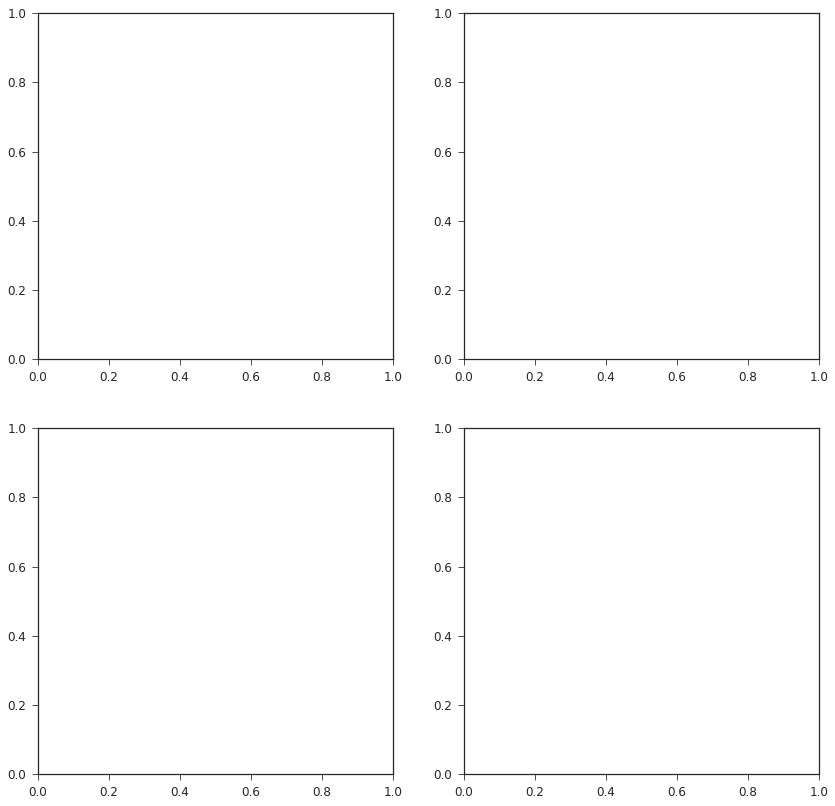

In [51]:
fig = scanalysis.plots.plot.FigureGrid(4,max_cols=2, scale=7)

In [24]:
import numpy as np

0 Axes(0.125,0.536818;0.227941x0.343182)
1 Axes(0.398529,0.536818;0.227941x0.343182)
2 Axes(0.672059,0.536818;0.227941x0.343182)
3 Axes(0.125,0.125;0.227941x0.343182)


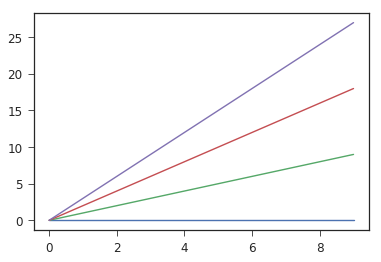

In [25]:
for i, ax in enumerate(fig):
    print(i , ax)
    plt.plot(np.arange(10) * i)

In [26]:
ax3 = fig[3]

In [33]:
fig.axes

{0: <matplotlib.axes._subplots.AxesSubplot at 0x10d3da940>,
 1: <matplotlib.axes._subplots.AxesSubplot at 0x10d510400>,
 2: <matplotlib.axes._subplots.AxesSubplot at 0x10d518cc0>,
 3: <matplotlib.axes._subplots.AxesSubplot at 0x10d2cd4a8>}

In [34]:
ax3.set_title("I'm axis 3")

In [ ]:
fig = plt.figure(figsize=[15, 12])
genes = ['CDH1', 'VIM', 'EZH2', 'ZEB1']
for i in range(len(genes)):
    ax = fig.add_subplot(gs[i//2, i%2])
    scdata.scatter_gene_expression(genes=['PC2', 'PC3'], color=genes[i], fig=fig, ax=ax)

In [15]:
temp.columns = ['PC1','PC2','PC3','PC4','PC5']

In [8]:
temp

,PC1,PC2,PC3,PC4,PC5
W29956,0.074972,-0.191587,-0.119149,-0.217170,0.113008
W30018,0.000558,-0.204520,-0.148149,-0.213746,0.118565
W30161,0.176868,-0.184069,-0.175023,-0.358310,0.148426
W30203,0.023297,-0.274966,-0.132949,-0.240905,0.108025
W30258,0.081680,-0.316567,-0.243547,-0.303318,-0.050524
W30296,-0.251958,-0.260204,-0.255429,-0.243747,0.176038
W30301,-0.078236,-0.393959,-0.366573,-0.222263,0.051706
W30306,-0.007170,-0.358824,-0.202952,-0.246437,-0.010374
W31106,-0.315401,-0.136304,-0.122165,-0.191190,0.099055
W31108,-0.315221,-0.066132,-0.091635,-0.129344,0.091457


In [14]:
import scanalysis

ValueError: 'color' kwarg must be an mpl color spec or sequence of color specs.
For a sequence of values to be color-mapped, use the 'c' kwarg instead.

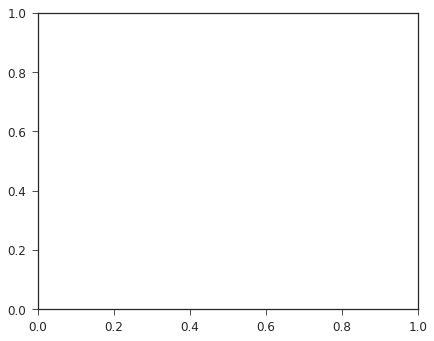

In [7]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=[15, 12])
genes = ['SRRM1', 'TAB2', 'CBR1', 'GPX4']
for i in range(len(genes)):
    ax = fig.add_subplot(gs[i//2, i%2])
    scanalysis.plots.plot.scatter_gene_expression(temp, genes=['PC2', 'PC3'], color=genes[i], fig=fig, ax=ax)

In [10]:
scanalysis.plots.plot.qualitative_colors(2)[1]

(0.21568627450980393, 0.49411764705882355, 0.72156862745098038)

In [24]:
data

,SRRM1,ZFP106,TAB2,TXNRD2,GRINL1A,SSRP1,EPDR1,GPX4,ALOX5AP,CDK5R1,...,ERO1L,POC1A,NFATC3,ERP29,HYOU1,BC024571,SCNN1A,CBR1,GTF2I,AK153575
W29956,0.000000,0.000000,1.189415,0.000000,1.189415,0.000000,0.0,1.189415,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.189415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
W30018,1.302822,0.000000,0.000000,0.000000,1.302822,5.211289,0.0,0.000000,0.000000,0.000000,...,0.000000,1.302822,1.302822,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.302822
W30161,4.095923,0.000000,0.000000,0.000000,0.000000,8.191847,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
W30203,0.777070,0.000000,0.000000,0.000000,0.000000,1.554140,0.0,1.554140,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.554140,0.000000,0.777070,0.000000,0.000000,3.108280,0.000000
W30258,1.269889,0.000000,0.000000,1.269889,1.269889,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.269889,0.000000,0.000000,0.000000,0.000000,1.269889,0.000000
W30296,0.000000,0.000000,0.000000,0.000000,2.041841,0.000000,0.0,0.000000,1.020921,0.000000,...,0.000000,0.000000,0.000000,7.146443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
W30301,0.000000,0.000000,0.000000,2.965278,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.930555,0.000000,0.000000
W30306,0.000000,0.000000,0.000000,0.000000,1.936508,0.000000,0.0,1.936508,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.809524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
W31106,1.323005,0.000000,0.000000,0.000000,0.661503,1.323005,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.630519,0.000000,0.661503,0.000000,0.000000,1.323005,0.000000
W31108,1.661479,1.246109,0.000000,0.000000,0.830739,2.076848,0.0,0.415370,0.000000,0.000000,...,0.830739,0.000000,0.830739,1.246109,1.246109,0.000000,0.000000,0.415370,1.661479,0.000000


In [3]:
import magic
import os

In [4]:
scdata = magic.mg.SCData.from_csv(os.path.expanduser('~/scanalysis/data/sample_scseq_data.csv'),data_type='sc-seq', normalize=False)

In [6]:
scdata.run_pca()

In [7]:
scdata.extended_data

data                                                             \
       SRRM1 ZFP106 TAB2 TXNRD2 GRINL1A SSRP1 EPDR1 GPX4 ALOX5AP CDK5R1   
W29956     0      0    1      0       1     0     0    1       0      0   
W30018     1      0    0      0       1     4     0    0       0      0   
W30161     1      0    0      0       0     2     0    0       0      0   
W30203     1      0    0      0       0     2     0    2       0      0   
W30258     1      0    0      1       1     0     0    0       0      0   
W30296     0      0    0      0       2     0     0    0       1      0   
W30301     0      0    0      1       0     0     0    0       0      0   
W30306     0      0    0      0       1     0     0    1       0      0   
W31106     2      0    0      0       1     2     0    0       0      0   
W31108     4      3    0      0       2     5     0    1       0      0   
W31110     3      0    0      0       0     1     0    0       2      0   
W31117     0      0    0      0       1     0     0    0       0      0   
W31118     1      2    0      0       0     4     0    0       0      0   
W31119     5      1    0      0       1     1     0    0       0      0   
W31129     2      0    0      0       0     4     0    1       0      1   
W31130     0      0    0      0       1     0     0    0       0      0   
W31131     5      1    0      0       2     2     0    0       0      0   
W31141     0      1    0      0       0     3     0    0       1      0   
W31145     2      1    0      0       0     3     0    1       0      0   
W31148     3      1    0      0       0     6     0    0       0      0   
W31152     1      1    0      0       0     4     0    0       0      0   
W31157     0      0    1      1       0     3     0    0       0      0   
W31158     4      0    0      0       0     0     0    0       0      0   
W31160     0      1    0      0       0     0     0    1       0      0   
W31164     3      1    0      0       1     1     0    0       0      0   
W31166     3      1    0      0       0     4     0    0       0      1   
W31168     6      0    1      0       1     7     0    0       0      0   
W31169     5      1    0      0       0     0     0    0       0      0   
W31170     5      6    0      0       2     4     0    0       0      0   
W31174     0      0    0      0       1     1     0    0       0      0   
...      ...    ...  ...    ...     ...   ...   ...  ...     ...    ...   
W75961     2      1    1      0       3     0     0    0       0      0   
W75964     4      0    0      0       0     2     0    0       0      0   
W75965     0      2    0      1       2     0     0    1       0      0   
W75966     3      0    0      1       0     2     0    0       0      0   
W75968     1      0    0      0       2     0     0    1       0      0   
W75969     0      1    1      1       1     0     0    1       0      0   
W75974     0      0    0      0       2     0     0    0       0      0   
W75977     3      2    0      0       2     3     0    0       0      0   
W75993     2      0    0      1       2     9     0   10       0      0   
W75996     0      0    0      0       0     0     0    0       0      0   
W76001     2      0    0      0       1     0     0    0       2      0   
W76042     6      0    0      1       0     4     0    2       0      0   
W76054     1      0    0      0       0     1     0    0       0      0   
W76062     4      1    0      0       2     1     0    1       0      0   
W76063     1      0    0      0       0     0     0    0       0      0   
W76070     3      0    1      2       4     4     0    3       0      0   
W76071     0      0    0      0       1     0     0    1       0      0   
W76089     3      0    0      0       2     3     0    2       2      0   
W76149     3      1    0      0       2     2     0    7       0      0   
W76150     4      0    0      1       0     5     0    2       1      0   
W76151     4      5    0      2  

#### PC2 vs PC3 colored by CDH1, VIM, FN1 and ZEB1 (after MAGIC):

### tSNE scatter plots

#### tSNE maps colored by CDH1, VIM, FN1, and ZEB1 (before MAGIC):

#### tSNE maps colored by CDH1, VIM, FN1, and ZEB1 (after MAGIC):

<a id="savefig"></a>
## Saving figures
You can save a figure as a png file using "savefig" as shown below.

In [ ]:
scanalysis.plots.plot.savefig(fig, 'h')

### original MAGIC package....

In [ ]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(scdata.data, ['SRRM1', 'TAB2'], color = 'GPX4')

In [ ]:
fig, ax = scdata.scatter_gene_expression(['SRRM1', 'TAB2'], color = 'GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')

In [ ]:
scdata.run_magic()

In [ ]:
scdata.magic.scatter_gene_expression(['SRRM1', 'TAB2'], color = 'GPX4')

In [ ]:
fig, ax = scdata.scatter_gene_expression(['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')

In [ ]:
fig, ax = scdata.magic.scatter_gene_expression(['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')

<a id="palantir"></a>
## Running Palantir

First, load the pickle file with the data. The data is normalized and log transformed. 

Use the following parameters for this particular data set:
* start_cell: Run5_126835192163230
* num_waypoints: 300
* flock = 0

In [2]:
import scanalysis

In [3]:
mb_data = scanalysis.io.loadsave.load("~/mb_data.p")

Successfully loaded /Users/hjin/mb_data.p


In [4]:
import pandas as pd
import numpy as np

In [5]:
mb = pd.DataFrame.transpose(mb_data)

In [5]:
mb

,KCTD15,STT3B,NAT6,FHL2,SP140L,DOCK9,CENPN,NEDD9,HIST1H2AM,TEK,...,ZNF543,SGTB,EEF1A1,TSPAN33,DNAJC4,SAG,FARP1,EXTL2,ZDHHC17,GOLPH3
Run4_120703408880541,-3.321928,-3.321928,-3.321928,0.171306,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,...,-3.321928,-3.321928,6.448183,-3.321928,1.105781,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928
Run4_120703409056541,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,...,-3.321928,-3.321928,6.536806,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928
Run4_120703409580963,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,...,-3.321928,-3.321928,5.660550,-3.321928,1.840569,-3.321928,-3.321928,-3.321928,0.880299,0.880299
Run4_120703423990708,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,...,-3.321928,-3.321928,6.120207,-3.321928,0.574557,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928
Run4_120703424252854,-3.321928,-0.365265,-3.321928,-3.321928,-3.321928,-3.321928,-0.365265,-3.321928,-0.365265,-3.321928,...,-3.321928,-3.321928,6.740922,-3.321928,-3.321928,-3.321928,-3.321928,0.538690,-3.321928,-0.365265
Run4_120703436876077,-3.321928,-3.321928,0.363786,0.363786,0.363786,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,...,-3.321928,-3.321928,6.833304,-3.321928,1.306611,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928
Run4_120703455025387,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-0.270688,-3.321928,-3.321928,-3.321928,...,-3.321928,-3.321928,6.987921,-0.270688,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928
Run4_120726911638237,-3.321928,0.918170,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-0.521655,-3.321928,...,-3.321928,-3.321928,6.682439,-3.321928,-0.521655,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928
Run4_120726912355038,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,...,-3.321928,-3.321928,6.426178,-3.321928,-0.098613,-3.321928,-3.321928,-0.098613,-3.321928,-3.321928
Run4_120726924974443,-3.321928,-0.910988,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,-0.910988,-3.321928,-3.321928,...,-3.321928,-3.321928,6.795428,-3.321928,-3.321928,-3.321928,-3.321928,-0.910988,-0.910988,-0.910988


In [6]:
DMEigVals = scanalysis.io.loadsave.load("~/palantir/dm_eig_vals.csv")

Successfully loaded /Users/hjin/palantir/dm_eig_vals.csv


In [7]:
DMEigs = scanalysis.io.loadsave.load("~/palantir/dm_eigs.csv")

Successfully loaded /Users/hjin/palantir/dm_eigs.csv


Note: the run_multibranch function takes ~10 minutes.

In [ ]:
atrajectory = scanalysis.io.loadsave.load("~/palantir/trajectory.csv")

In [ ]:
#pca
r1, r2 = scanalysis.utils.pca.run_pca(mb_data) 

#tsne
t1 = scanalysis.utils.tsne.TSNE()
d1 = t1.fit_transform(r1)

#plot tsne
fig, ax = scanalysis.plots.plot.plot_tsne(d1)

^ not exactly sure if this is correct

In [8]:
res = scanalysis.tools.pr.palantir.run_multibranch(data_ = mb, DMEigs = DMEigs, DMEigVals = DMEigVals, dm_eigs = [1,2], start_cell="Run5_126835192163230", num_waypoints = 300, flock = 0)


Sampling and flocking waypoints...
Time for determining waypoints: 0.00276490052541097 minutes
Shortest path distances...
Time for shortest paths: 6.559225936730702 minutes
Determining perspectives, trajectory...
Correlation at iteration 1: 1.0000
Determining terminal states...
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


/usr/local/lib/python3.6/site-packages/scanalysis/tools/pr/palantir.py:162: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(pairwise_distances(data.loc[cells,:]))
/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [9]:
res['trajectory']

Run4_120703408880541    2.285284
Run4_120703409056541    0.074911
Run4_120703409580963    0.690756
Run4_120703423990708    0.689246
Run4_120703424252854    0.859093
Run4_120703436876077    0.302394
Run4_120703455025387    0.665594
Run4_120726911638237    0.743708
Run4_120726912355038    0.542414
Run4_120726924974443    0.634651
Run4_120726924978030    0.482703
Run4_120726943295348    0.713043
Run4_120726943845302    0.736564
Run4_120772961130853    0.346495
Run4_120786758780660    0.321621
Run4_120786786086116    0.203215
Run4_120786804205803    0.745397
Run4_120786804401973    0.566797
Run4_120797898099934    0.772317
Run4_120797925428019    0.518495
Run4_120797944278244    2.415211
Run4_120797944309486    2.223395
Run4_120797944462237    0.435271
Run4_120797944538971    1.664613
Run4_120797945084765    0.302292
Run4_120864497952619    0.965669
Run4_121202296155437    2.508744
Run4_121202296712412    0.884721
Run4_121202296875939    0.113362
Run4_121202311609131    0.680648
          

Compare trajectory results with the trajectory.csv file using a scatter plot, shown below.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(res['trajectory'], atrajectory)

<a id="prplot"></a>
## Plotting Palantir Results

In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

First, create an instance of the DiffEntrResults class.

In [9]:
der = scanalysis.plots.pr_plot.DiffEntrResults(trajectory = res['trajectory'], branches = None, branch_prob=res['branch_probs'], no_bins=1)

Here, we will try the first five genes in the data matrix. You shouldn't plot all the markers because that will kill your computer.  

In [10]:
mb_data_f5 = mb_data.iloc[0:5,:]

We need the data to be in cells x genes format (index x columns), so we will switch the rows and columns.

In [23]:
a = pd.DataFrame.transpose(mb_data_f5)

In [35]:
a

,KCTD15,STT3B,NAT6,FHL2,SP140L
Run4_120703408880541,-3.321928,-3.321928,-3.321928,0.171306,-3.321928
Run4_120703409056541,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928
Run4_120703409580963,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928
Run4_120703423990708,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928
Run4_120703424252854,-3.321928,-0.365265,-3.321928,-3.321928,-3.321928
Run4_120703436876077,-3.321928,-3.321928,0.363786,0.363786,0.363786
Run4_120703455025387,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928
Run4_120726911638237,-3.321928,0.918170,-3.321928,-3.321928,-3.321928
Run4_120726912355038,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928
Run4_120726924974443,-3.321928,-0.910988,-3.321928,-3.321928,-3.321928


Run the plot_markers function to visualize results.

In [13]:
der.branch_prob

,Run4_235626713532342,Run5_239477254471070
Run4_120703408880541,0.999998,0.000000
Run4_120703409056541,0.182656,0.817344
Run4_120703409580963,0.010092,0.989908
Run4_120703423990708,0.010411,0.989589
Run4_120703424252854,0.000000,0.998499
Run4_120703436876077,0.088207,0.911793
Run4_120703455025387,0.016095,0.983905
Run4_120726911638237,0.000000,0.992499
Run4_120726912355038,0.039662,0.960338
Run4_120726924974443,0.017445,0.982555


In [31]:
der.plot_markers(a)

Run4_235626713532342


KeyError: "None of [Index(['KCTD15', 'STT3B', 'NAT6', 'FHL2', 'SP140L'], dtype='object')] are in the [index]"

Run4_235626713532342
Time for processing Run4_235626713532342: 0.004646170139312744 minutes
Run5_239477254471070
Time for processing Run5_239477254471070: 0.005591368675231934 minutes


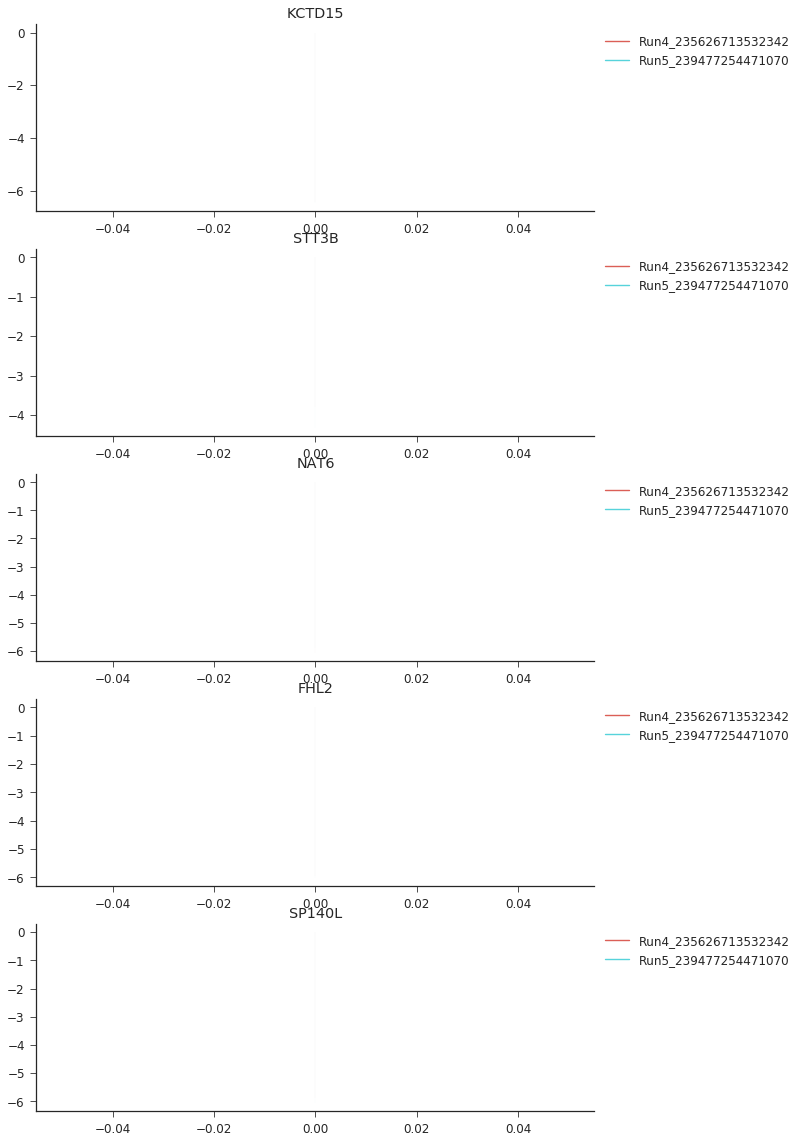

In [13]:
der.plot_markers(mb_data_f5)

In [13]:
mb_data_f5.shape[0]

5

In [25]:
der.branch_prob.columns

Index(['Run4_235626713532342', 'Run5_239477254471070'], dtype='object')

In [28]:
weights = der.branch_prob.loc[mb_data_f5.columns,'Run4_235626713532342' ]

In [29]:
weights

Run4_120703408880541    0.999997
Run4_120703409056541    0.144511
Run4_120703409580963    0.016099
Run4_120703423990708    0.016543
Run4_120703424252854    0.000000
Run4_120703436876077    0.078912
Run4_120703455025387    0.030889
Run4_120726911638237    0.021286
Run4_120726912355038    0.036232
Run4_120726924974443    0.023710
Run4_120726924978030    0.050166
Run4_120726943295348    0.015151
Run4_120726943845302    0.012988
Run4_120772961130853    0.070063
Run4_120786758780660    0.074233
Run4_120786786086116    0.119245
Run4_120786804205803    0.016530
Run4_120786804401973    0.033288
Run4_120797898099934    0.000000
Run4_120797925428019    0.053342
Run4_120797944278244    0.999999
Run4_120797944309486    0.999993
Run4_120797944462237    0.058725
Run4_120797944538971    0.999247
Run4_120797945084765    0.079301
Run4_120864497952619    0.000000
Run4_121202296155437    1.000000
Run4_121202296712412    0.000000
Run4_121202296875939    0.145640
Run4_121202311609131    0.017054
          

In [14]:
der.compute_marker_trends(mb_data_f5, der.branch_prob.columns, True, n_jobs=1)

Run4_235626713532342


ValueError: cannot reshape array of size 5 into shape (5,500)

In [16]:
len(der.traj_bins)

500

In [18]:
mb_data_f5.shape[0]

5

In [14]:
weights = der.branch_prob.loc[mb_data_f5.columns, 'Run4_235626713532342']

In [15]:
from joblib import Parallel, delayed
res1 = Parallel(n_jobs=1)(
				delayed(der._marker_trends_helper)(mb_data_f5.loc[gene,:], weights, True)
				for gene in mb_data_f5.index)

In [16]:
der.traj_bins

array([ 0.])

In [17]:
np.linspace(np.min(der.trajectory), np.max(der.trajectory), 1)

array([ 0.])

In [18]:
len(res1)

5

In [19]:
trends = [res1[i][0] for i in range(len(res1))]

In [20]:
trends

[-3.2292507934645425,
 -1.9282259277588403,
 -3.0264112873070923,
 -3.0360587128885284,
 -2.9685145636799564]

In [21]:
np.ravel(trends).reshape([mb_data_f5.shape[0], len(der.traj_bins)])

array([[-3.22925079],
       [-1.92822593],
       [-3.02641129],
       [-3.03605871],
       [-2.96851456]])

In [22]:

np.ravel(trends).reshape([mb_data_f5.shape[0], 
					1])

array([[-3.22925079],
       [-1.92822593],
       [-3.02641129],
       [-3.03605871],
       [-2.96851456]])

In [29]:
stds = [res1[i][1] for i in range(len(res))]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [34]:
res1

[array([-3.22925079]),
 array([-1.92822593]),
 array([-3.02641129]),
 array([-3.03605871]),
 array([-2.96851456])]

<a id="ref"></a>
## References

Setty M, Tadmor MD, Reich-Zeliger S, Angel O, Salame TM, Kathail P, Choi K, Bendall S, Friedman N, Pe’er D. "Wishbone identifies bifurcating developmental trajectories from single-cell data." Nat. Biotech. 2016 April 12. <http://dx.doi.org/10.1038/nbt.3569>

van Dijk, David, et al. "MAGIC: A diffusion-based imputation method reveals gene-gene interactions in single-cell RNA-sequencing data." BioRxiv (2017): 111591. <http://www.biorxiv.org/content/early/2017/02/25/111591>